# BERT for Cyberbullying Detection

Fine-tuning BERT on Jigsaw Toxic Comment dataset (20k subset)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/DL_cyber_data/train.csv'

Mounted at /content/drive


In [2]:
!pip install -q transformers

In [3]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

CUDA available: True
Device: Tesla T4


In [4]:
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import time

In [5]:
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.FloatTensor(self.labels[idx])
        }

In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, n_classes, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(self.dropout(pooled))

In [7]:
def accuracy_multilabel(preds, labels):
    preds = (torch.sigmoid(preds) > 0.5).float()
    return (preds == labels).float().mean()

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_acc = 0, 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_multilabel(preds, labels).item()
    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            preds = model(input_ids, attention_mask)
            total_loss += criterion(preds, labels).item()
            total_acc += accuracy_multilabel(preds, labels).item()
    return total_loss / len(loader), total_acc / len(loader)

def get_predictions(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            preds = torch.sigmoid(model(batch['input_ids'].to(device),
                                       batch['attention_mask'].to(device))) > 0.5
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch['labels'].numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

In [8]:
df_full = pd.read_csv(DATA_PATH)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(f"Total: {len(df_full)}")
print(f"\nLabels:\n{df_full[label_cols].sum()}")

Total: 159571

Labels:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [9]:
df_full['num_labels'] = df_full[label_cols].sum(axis=1)
print("Number of labels per comment:")
print(df_full['num_labels'].value_counts().sort_index())

Number of labels per comment:
num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64


In [10]:
print("Sample comments:")
for i in range(2):
    text = df_full['comment_text'].iloc[i][:100]
    print(f"\n{i+1}. {text}...")
    labels = [label_cols[j] for j in range(len(label_cols)) if df_full[label_cols[j]].iloc[i] == 1]
    print(f"   Labels: {labels if labels else ['clean']}")

Sample comments:

1. Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't ...
   Labels: ['clean']

2. D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11...
   Labels: ['clean']


In [11]:
df = df_full.sample(20000, random_state=42)
print(f"\nUsing {len(df)} samples for BERT training")


Using 20000 samples for BERT training


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df['comment_text'].values, df[label_cols].values, test_size=0.2, random_state=42
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 16000, Test: 4000


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_loader = DataLoader(BERTDataset(X_train, y_train, tokenizer), batch_size=16, shuffle=True)
test_loader = DataLoader(BERTDataset(X_test, y_test, tokenizer), batch_size=16)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(len(label_cols)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
print(f"Device: {device}\nParams: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Device: cuda
Params: 109.5M


In [15]:
train_losses, test_losses, train_accs, test_accs = [], [], [], []
start = time.time()

for epoch in range(3):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.3f} Acc: {train_acc:.3f} | Test Loss: {test_loss:.3f} Acc: {test_acc:.3f}')

print(f"\nTime: {(time.time()-start)/60:.1f} min")

Epoch 1 | Train Loss: 0.082 Acc: 0.976 | Test Loss: 0.054 Acc: 0.982
Epoch 2 | Train Loss: 0.042 Acc: 0.985 | Test Loss: 0.045 Acc: 0.983
Epoch 3 | Train Loss: 0.033 Acc: 0.988 | Test Loss: 0.046 Acc: 0.983

Time: 19.8 min


In [16]:
y_pred, y_true = get_predictions(model, test_loader, device)
overall = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
print(f"\nOverall - Precision: {overall[0]:.4f}, Recall: {overall[1]:.4f}, F1: {overall[2]:.4f}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

print("\nPer-label F1:")
for i, label in enumerate(label_cols):
    f1 = precision_recall_fscore_support(y_true[:, i], y_pred[:, i], average='binary', zero_division=0)[2]
    print(f"{label}: {f1:.4f}")


Overall - Precision: 0.8128, Recall: 0.7026, F1: 0.7455
Accuracy: 0.9233

Per-label F1:
toxic: 0.8148
severe_toxic: 0.3571
obscene: 0.8102
threat: 0.0000
insult: 0.7185
identity_hate: 0.2727


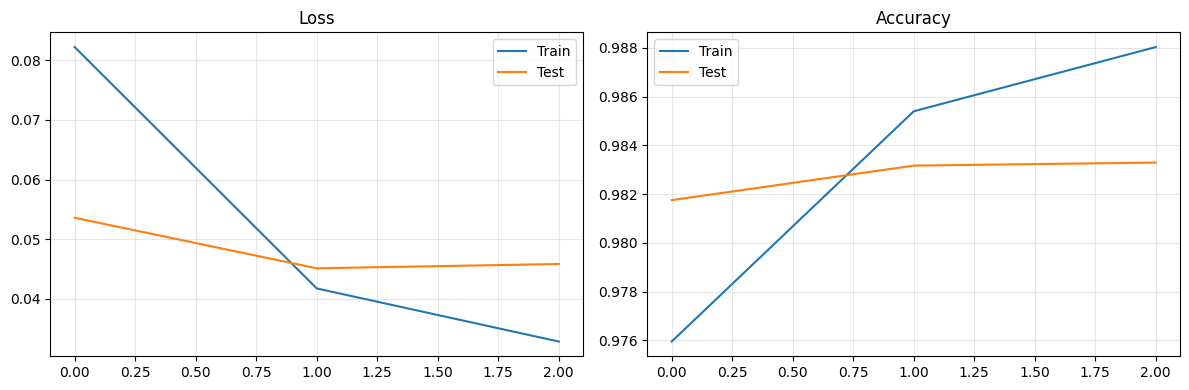

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train')
axes[0].plot(test_losses, label='Test')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[1].plot(train_accs, label='Train')
axes[1].plot(test_accs, label='Test')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
torch.save(model.state_dict(), 'bert_model.pt')